In [1]:
from carla import Benchmark
from IPython.display import display
import carla.evaluation.catalog as evaluation_catalog
from carla.data.catalog import OnlineCatalog
from carla.models.catalog import MLModelCatalog
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog
import shap 
from sklearn.preprocessing import OrdinalEncoder
from carla.data.causal_model import CausalModel
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from carla.data.catalog import CsvCatalog
import numpy as np 

import warnings
warnings.filterwarnings("ignore")

/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacqueline/.local/share/virtualenvs/CARLA-koH0yuP4/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint

[INFO] Using Python-MIP package version 1.12.0 [model.py <module>]


In [2]:
scm = CausalModel("credit")

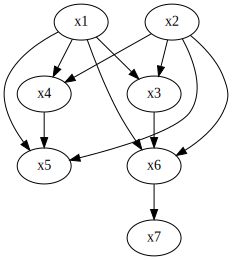

In [3]:
scm.cgm.draw()

In [4]:

dataset = scm.generate_dataset(1000)
dataset.df.to_csv('credit_synthetic.csv',index=False)
display(dataset.df)

,label,x1,x2,x3,x4,x6,x5,x7
0,0.0,1.0,-5.374302,0.028619,-1.129844,-2.744300,-0.625192,2.084647
1,0.0,1.0,-5.210871,-0.192705,1.904234,4.607893,3.063371,2.285584
2,1.0,0.0,2.373330,-0.233179,-0.697765,-0.103181,-0.879360,-2.617862
3,0.0,0.0,-13.385995,-0.164042,0.581720,-1.169078,-0.305056,-0.719612
4,1.0,1.0,3.477485,-0.002458,4.699787,1.641210,5.695354,-0.277160
...,...,...,...,...,...,...,...,...
995,0.0,1.0,-15.316467,-0.169398,0.106817,-3.640827,-2.903189,-3.661007
996,1.0,0.0,2.346044,-0.092425,0.204575,-1.530660,-1.131548,-5.526926
997,0.0,1.0,-17.451622,-0.059597,-4.869311,-0.413393,-6.467327,-3.452923
998,1.0,0.0,-2.465504,-0.161200,2.130428,-1.651074,-2.197170,5.218185


In [5]:
'''Build Dataset for Wachter'''
import pandas as pd
# Load Data 
dataframe = pd.read_csv('./credit_synthetic.csv')
continuous = dataframe.drop(columns=['label']).columns

dataset = CsvCatalog(file_path="credit_synthetic.csv",
                     continuous=continuous,
                     categorical=[],
                     immutables=[],
                     target='label')

In [6]:
#Model 

training_params = {"lr": 0.01, "epochs": 3, "batch_size": 16, "hidden_size": [18, 9, 2]}

ml_model = MLModelCatalog(
    dataset, model_type="ann", load_online=False, backend="pytorch"
)
ml_model.train(
    learning_rate=training_params["lr"],
    epochs=training_params["epochs"],
    batch_size=training_params["batch_size"],
    hidden_size=training_params["hidden_size"],
    force_train=True
)


balance on test set 0.49066666666666664, balance on test set 0.492
Epoch 0/2
----------
train Loss: 0.5947 Acc: 0.6680

test Loss: 0.5683 Acc: 0.7240

Epoch 1/2
----------
train Loss: 0.4310 Acc: 0.8013

test Loss: 0.4949 Acc: 0.7520

Epoch 2/2
----------
train Loss: 0.3707 Acc: 0.8240

test Loss: 0.4141 Acc: 0.8000



In [7]:
from carla.models.negative_instances import predict_negative_instances
import carla.recourse_methods.catalog as recourse_catalog

factuals = predict_negative_instances(ml_model, dataset.df)
test_factual = factuals.iloc[:25]

display(test_factual)

,label,x1,x2,x3,x4,x6,x5,x7
0,0.0,1.0,0.264942,0.573268,0.633194,0.297634,0.515974,0.537355
3,0.0,0.0,0.152185,0.302672,0.701577,0.392132,0.528429,0.466921
6,1.0,0.0,0.344386,0.501847,0.783556,0.292421,0.674749,0.241932
10,0.0,1.0,0.304560,0.387983,0.687191,0.549831,0.360148,0.410770
11,0.0,0.0,0.123327,0.147640,0.536624,0.317858,0.315270,0.270750
12,1.0,0.0,0.290445,0.461948,0.681572,0.307808,0.555568,0.385659
13,0.0,0.0,0.282091,0.363074,0.762456,0.583355,0.426068,0.575325
15,0.0,0.0,0.259855,0.050772,0.726107,0.485632,0.380544,0.521276
16,0.0,0.0,0.297998,0.530258,0.609771,0.286805,0.440576,0.122729
19,0.0,0.0,0.182153,0.350120,0.643757,0.255335,0.413095,0.379274


In [8]:
hyperparams = {"loss_type": "BCE"}

recourse_method = recourse_catalog.Wachter(ml_model, hyperparams)
cfs = recourse_method.get_counterfactuals(test_factual)


[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactual Explanation Found [wachter.py wachter_recourse]
[INFO] Counterfactua

In [80]:
def get_pred_from_causal(scm,values,cf_label, mapping_dict):
    #TODO change everything hard coded
    values['target']=cf_label
    #print(values)
    def _get_noise_string(node):
        def _get_node_id(node):
            return node[1:]
        if not node[0] == "x":
            raise ValueError
        return "u" + _get_node_id(node)
    exogenous_variables = np.concatenate(
        [
            #np.array(scm.noise_distributions[node].sample(1)).reshape(-1, 1)
            np.array(values[mapping_dict[node]]).reshape(-1, 1)
            for node in scm.get_topological_ordering("exogenous")
        ],
        axis=1,
    )
    exogenous_variables = pd.DataFrame(
        exogenous_variables, columns=scm.get_topological_ordering("exogenous")
    )

    endogenous_variables =exogenous_variables.copy() # np.array(values[mapping_dict[node]]).reshape(-1, 1)
    endogenous_variables = endogenous_variables.rename(
        columns=dict(
            zip(
                scm.get_topological_ordering("exogenous"),
                scm.get_topological_ordering("endogenous"),
            )
        )
    )
    # used later to make sure parents are populated when computing children
    endogenous_variables.loc[:] = np.nan
    for node in scm.get_topological_ordering("endogenous"):
        #print(node)
        parents = scm.get_parents(node)
        if endogenous_variables.loc[:, list(parents)].isnull().values.any():
            raise ValueError(
                "parents in endogenous_variables should already be occupied"
            )
        #print(_get_noise_string(node))
        endogenous_variables[node] = scm.structural_equations_np[node](
            exogenous_variables[_get_noise_string(node)],
            *[endogenous_variables[p] for p in parents],


        )
    # fix a hyperplane
    w = np.ones((endogenous_variables.shape[1], 1))
    # get the average scale of (w^T)*X, this depends on the scale of the data
    scale = 2.5 / np.mean(np.abs(np.dot(endogenous_variables, w)))
    predictions = 1 / (1 + np.exp(-scale * np.dot(endogenous_variables, w)))

    #if not 0.20 < np.std(predictions) < 0.42:
    #    raise ValueError(f"std of labels is strange: {np.std(predictions)}")

    # sample labels from class probabilities in predictions
    uniform_rv = np.random.rand(endogenous_variables.shape[0], 1)
    labels = int(uniform_rv < predictions)
    #labels = pd.DataFrame(data=labels, columns={"label"})
    #print('labels', labels)
    #labels=endogenous_variables['x7'][0]
    
    return labels

In [81]:
mapping_dict={ 
    # Gender
      'u1': 'x1',
      # Age
      'u2': 'x2',
      # Education
      'u3': 'x3',
      # Loan amount
      'u4':'x4',
      # Loan duration
      'u5': 'x5',
      # Income
      'u6': 'x6',
      # Savings
      'u7':'x7',
}

In [94]:
from cmath import nan
from telnetlib import SE
from carla.data import causal_model
from carla.evaluation import remove_nans
from carla.evaluation.api import Evaluation
class Sematic(Evaluation):
    """
    Semnatic Evaluation Metric.
    Attributes: 
        ml_model: Machine Learning Model
        causal_graph: ground truth causal graph
        mapping_dict: name mapping
    """

    def __init__(self, ml_model, causal_graph,mapping_dict):
        self.ml_model= ml_model
        self.causal_graph=causal_graph
        self.mapping_dict=mapping_dict
    def get_evaluation(self,factuals: np.ndarray, counterfactuals: np.ndarray):
        # generate data 
        cf_label=self.ml_model.predict(np.array(counterfactuals.values).reshape(-1,counterfactuals.values.shape[-1]))
        print('cflabel', cf_label)
        if cf_label[0][0] > 0.5: 
            cf_label=1
        else:
            cf_label=0
        print(cf_label)
        #cf_label=np.argmax(cf_label)
        causal_label=get_pred_from_causal(self.causal_graph,counterfactuals,cf_label, self.mapping_dict)
        #print(cf_label)
        print('Causal',causal_label)
        if cf_label ==causal_label:
            return pd.DataFrame([[1]], columns=["semantic"])
        else: 
            return pd.DataFrame([[0]], columns=["semantic"])
'''Histogram Features / true Positive / false Positive'''
# first initialize the benchmarking class by passing
# black-box-model, recourse method, and factuals into it#
results=[]
i=0
#print(factuals.iloc[:20])
for a in test_factual.index:
    #print(test_factual.index)

    if str(cfs.iloc[i]['x1'])=='nan':
        pass
    else:
        sem= Sematic(ml_model,scm,mapping_dict)
        try:
            res=sem.get_evaluation(test_factual.iloc[a],cfs.iloc[i])['semantic'][0]
            results.append( res)
        except: 
            pass
    i=i+1


#benchmark = Benchmark(ml_model, recourse_method, factuals[:20])

# now you can decide if you want to run all measurements
# or just specific ones.
#evaluation_measures = [
#    Sematic(ml_model,scm,mapping_dict)
#]

#results = benchmark.run_benchmark(evaluation_measures)
results


cflabel [[0.50477284]]
1
labels 0
Causal 0
cflabel [[0.5020996]]
1
labels 0
Causal 0
cflabel [[0.5683797]]
1
labels 0
Causal 0
cflabel [[0.5091228]]
1
labels 0
Causal 0
cflabel [[0.55117023]]
1
labels 0
Causal 0
cflabel [[0.55982524]]
1
labels 0
Causal 0
cflabel [[0.54302466]]
1
labels 0
Causal 0
cflabel [[0.5551793]]
1
labels 0
Causal 0
cflabel [[0.5474928]]
1
labels 1
Causal 1
cflabel [[0.5479639]]
1
labels 0
Causal 0
cflabel [[0.5371695]]
1
labels 1
Causal 1


[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]

In [95]:
# Box Plot of
mean= np.mean(results)
std= np.std(results)
print(f'Semantic results {mean} +/- {std}')

Semantic results 0.18181818181818182 +/- 0.385694607919935


In [96]:
np.argwhere(np.array(results)==0)

array([[0],
       [1],
       [2],
       [3],
       [4],
       [5],
       [6],
       [7],
       [9]])

In [97]:
import seaborn as sns 
import matplotlib.pyplot as plt 
# Data Distribution
id_comp= np.where(np.array(results)==1)
id_not_comp=np.where(np.array(results)==0)
print(id_not_comp)
if len(id_comp[0])==0:
    cfs_complient=[]
    cfs_complient_predict=[]
    
else:
    cfs_complient=cfs[id_comp]
    cfs_complient_predict=np.max(ml_model.predict(np.array(cfs_complient.values).reshape(-1,cfs_complient.values.shape[-1])),axis=1)

print(id_not_comp[0])
cfs_not_complient=cfs.iloc[id_not_comp[0]]

print(cfs_not_complient)
#TODO

cfs_not_complient_predict=np.max(ml_model.predict(np.array(cfs_not_complient).reshape(-1,7)),axis=1)
print(cfs_not_complient_predict)

#df_complient = pd.DataFrame(np.array([cfs_complient_predict,cfs_not_complient_predict]), columns=['complient','not complient'])

(array([0, 1, 2, 3, 4, 5, 6, 7, 9]),)


TypeError: '(array([ 8, 10]),)' is an invalid key

[0.5047729 0.5020996 0.5683795 0.5091228 0.5511703 0.5598251 0.5430246
 0.5551793 0.5474928 0.5479639 0.5371694]


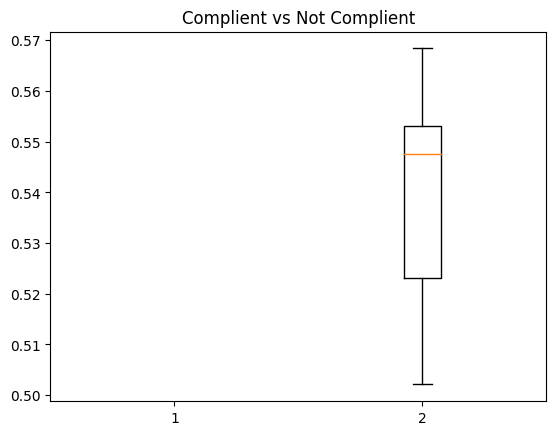

In [ ]:
#BoxPlot
# Drob na 
import  numpy
from math import nan, isnan
cfs_complient_predict = [x for x in cfs_complient_predict if isnan(x) == False]
cfs_not_complient_predict = [x for x in cfs_not_complient_predict if isnan(x) == False]
cfs_complient_predict=np.array(cfs_complient_predict).reshape(-1)
cfs_not_complient_predict=np.array(cfs_not_complient_predict).reshape(-1)

print(cfs_not_complient_predict)
data = [cfs_complient_predict,cfs_not_complient_predict]

fig7, ax7 = plt.subplots()
ax7.set_title('Complient vs Not Complient')
ax7.boxplot(data)

#plt.ylim((0.99,1))
plt.show()

In [ ]:
# Violin Plot 
